# Table of Contents

# Background

Michael wanted more colour in the gradients so the next step would be to generate a stack with RED->Yellow->Green

Marcus suggested using his [observable notebook](https://beta.observablehq.com/@magfoto/wavelengths-and-spectral-colours) to fine tune the calculations.

# Imports

In [1]:
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.ndimage
import scipy.misc
from skimage import color, io, img_as_float

gif generation lib

In [3]:
import imageio

# Functions

In [4]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [5]:
def showSegmentation(sliceNum=90):
    # Get slice
    idxSlice = sliceNum
    imgOriginal = image[:,:,idxSlice]

    # Apply smoothing
    imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                        timeStep=0.125,
                                        numberOfIterations=5)
    sitk_show(imgSmooth)

    # Get segmentation
    lstSeeds = [(75,60)]

    imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                                  seedList=lstSeeds, 
                                                  lower=0, 
                                                  upper=40,
                                                  replaceValue=labelWhiteMatter)

    # Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
    imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

    # Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
    sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

    # show segmentation
    sitk_show(imgWhiteMatter)

In [6]:
def getSmoothenImage(img):
    imgSmoothed = SimpleITK.CurvatureFlow(image1=img,
        timeStep=0.125,
        numberOfIterations=5)
    return imgSmoothed

In [7]:
def sitk_showColour(img, title=None, margin=0.05, dpi=40,cmapType="gray" ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap(cmapType)
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

# Parameters

In [8]:
inpath = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Monkey//10 sample Chimpanzee 3T for NCBR website//Male_Fritz.nii'
# inpath = "C://Cerebral//_MarioSandBox//DB//medicalHolography//UofT Mouse Brain//C57brain.mnc"

In [9]:
# Z slice of the DICOM files to process. In the interest of
# simplicity, segmentation will be limited to a single 2D
# image but all processes are entirely applicable to the 3D image
idxSlice = 50

# int labels to assign to the segmented white and gray matter.
# These need to be different integers but their values themselves
# don't matter
labelWhiteMatter = 1
labelGrayMatter = 2

# Reading Data

In [10]:
reader = SimpleITK.ImageFileReader()
image = SimpleITK.ReadImage(inpath)

# Display the data

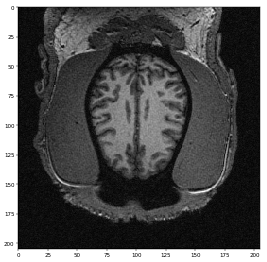

In [11]:
idxSlice = 50
imgOriginal = image[:,:,idxSlice]
sitk_show(imgOriginal)

# Smoothing

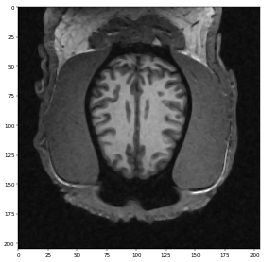

In [12]:
imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                    timeStep=0.125,
                                    numberOfIterations=5)

# blurFilter = SimpleITK.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# imgSmooth = blurFilter.Execute(imgOriginal)

sitk_show(imgSmooth)

We are basically just smoothing the images so that it doesn't have that grainy look to it.

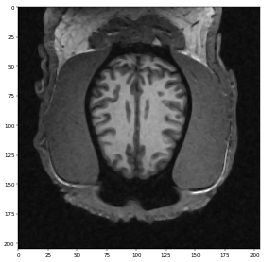

In [13]:
imgSmoothFun = getSmoothenImage(imgOriginal)

sitk_show(imgSmoothFun)

# Colour Mapping Variants

## Regular Gray Scale Image

In [14]:
colMap = ["gray"]

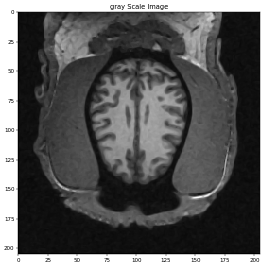

In [15]:
sitk_showColour(imgSmoothFun,title=colMap[0]+' Scale Image',cmapType=colMap[0])    

## Gradients

In [17]:
numSlices = image.GetDepth()

In [19]:
imageStackNumpy = []
for currentSliceInd in xrange(numSlices):
    currentSlice = image[:,:,currentSliceInd]
    currentSliceSmoothed = getSmoothenImage(currentSlice)
    numpyArraySlice = SimpleITK.GetArrayFromImage(currentSliceSmoothed)
    imageStackNumpy.append(numpyArraySlice)

Like in the previous notebook entitled "Monkey_CreateGradientColourSlices" to apply a mask I used the following tutorial in a [stackoverflow thread](https://stackoverflow.com/questions/9193603/applying-a-coloured-overlay-to-an-image-in-either-pil-or-imagemagik)

Using Marcus' [observable](https://beta.observablehq.com/@magfoto/wavelengths-and-spectral-colours) we know the following:

1. Red -> Yellow -> Green is the same in RGB as [1,0,0]->[1,1,0]->[0,1,0]
    - notice that the transitino from red to yellow means incrementing the green channel to 1 and from yellow to green the red channel is decrementing to 0.  We will use this observation to perform the transition.
    

2. Incrementing R and G channels means there is a range of 2 units to play with here and since there are numSlices worth of slices we can divide this by 2.  This will get us the incrementing factor.


3.  We also need a threshold at which we switch from incrementing G and decremning R.  There are two possibilities
    - When G reaches 1 decrement R
    - When we have gone through half the slices we decrement R
        - This option is better as we can reuse old code

In [42]:
alpha = 1.0
rgChannelRange = 2.0
th = numSlices/2.0
incrementalFactor = rgChannelRange/numSlices
decrementalFactor = rgChannelRange/numSlices

In [43]:
maskedImage = []
rChannel = 1.0
gChannel = 0.0
bChannel = 0.0

for sliceInd in xrange(numSlices):
    
        
    # get the image
    imgRaw = imageStackNumpy[sliceInd]
    img = imgRaw/imgRaw.max()
    rows, cols = img.shape
    color_mask = np.zeros((rows, cols, 3))
    
    # contruct colour image to superimpose
    color_mask[0:rows-1, 0:cols-1] = [rChannel, gChannel, bChannel]  # Red block
#     print("[{},{},{}]".format(rChannel, gChannel, bChannel))
          
    if(sliceInd<th):                     
        gChannel = gChannel+incrementalFactor
    else:
        rChannel = rChannel-decrementalFactor       
    
    
    # Construct RGB version of grey-level image
    img_color = np.dstack((img, img, img))
    
    # Convert the input image and color mask to Hue Saturation Value (HSV)
    # colorspace
    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    # Replace the hue and saturation of the original image
    # with that of the color mask
    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)
    
    maskedImage.append(img_masked)

# Gif Generation

In [37]:
dirGifOutput = "C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//gifs//"

## With Gradient Colour

In [44]:
imageio.mimsave(dirGifOutput+'fritzGradientRYG.gif',maskedImage)

# Image Stack Generation

In [45]:
imageStackOutFile = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//JPG Stacks - Colour Gradients RYG//'

In [48]:
for sliceInd in xrange(numSlices):
    imageio.imwrite(imageStackOutFile + '{}.jpg'.format(sliceInd), maskedImage[sliceInd])